# Agentic AI-Powered GIF Generator with LangGraph

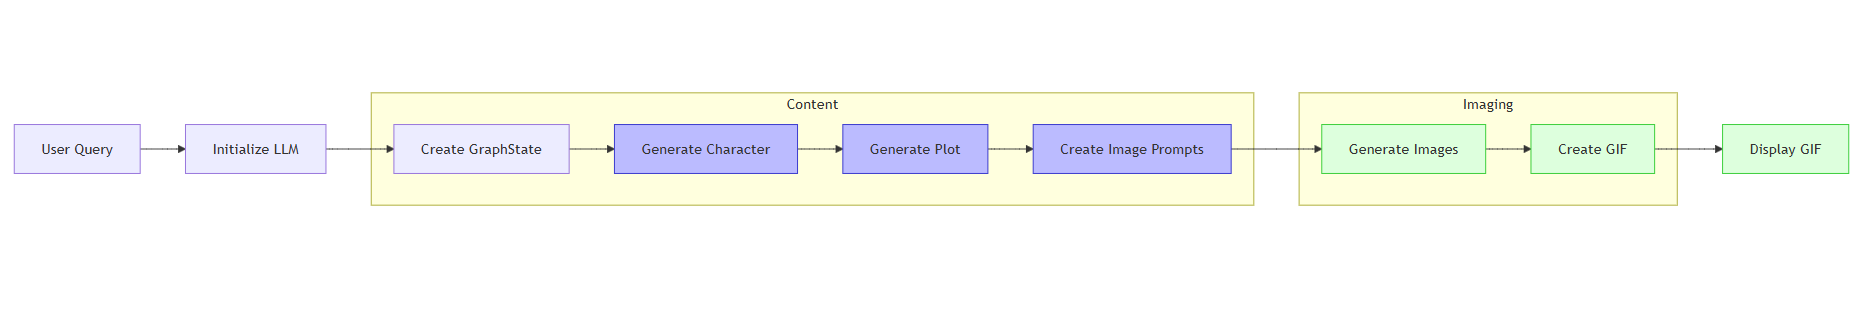



## Abstract

Imagine typing a simple prompt and watching as AI agents work together to bring your ideas to life as an animated story. This script does exactly that—leveraging the power of LangGraph to coordinate a team of specialized AI agents that transform text into captivating animated GIFs.

The magic happens through a seamless pipeline: a character agent first breathes life into your concept using Google's Gemini model, while a storytelling agent crafts a compelling narrative arc. These ideas are then translated into visually optimized prompts by a prompt engineering agent, before being rendered into striking images through Stable Diffusion. Finally, everything comes together as an assembly agent weaves these frames into a fluid animation.

Beyond just generating content, this system showcases the future of creative AI—where multiple agents collaborate intelligently to handle complex tasks that no single model could accomplish alone. With built-in resilience and detailed progress tracking, it represents a powerful example of how agentic AI and LangGraph are revolutionizing creative workflows and opening new frontiers in human-AI collaboration.

In [1]:
!pip install langgraph langchain-google-genai langchain-core google-generativeai pillow ipython aiohttp python-dotenv

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 847.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00


🔄 [System] Agentic AI system initialized. Establishing capabilities...

🌐 [Agent] Workflow schema established.
Enter your query for generating a GIF (e.g., A futuristic city with flying cars and neon lights): 
⚠️ [System] No query provided. Using default example.
🚀 [Agent] Initiating workflow for query: 'A futuristic city with flying cars and neon lights'...
✨ [Agent] Analyzing input to craft a detailed character description...
✅ [Agent] Character description generated successfully.
📖 [Agent] Generating a cohesive plot based on the character description...
✅ [Agent] Plot successfully crafted.
🖼️ [Agent] Designing Stable Diffusion optimized image prompts...
✅ [Agent] Stable Diffusion optimized image prompts prepared
🌟 [Agent] Generating images for all frames...
🌟 [Agent] Generating image 1: Kaito, a shadowy figure in a worn leather jacket, ...
🌟 [Agent] Generating image 2: Kaito and Ren, a brilliant but eccentric programme...
🌟 [Agent] Generating image 3: Close-up shot of Kaito's hands 

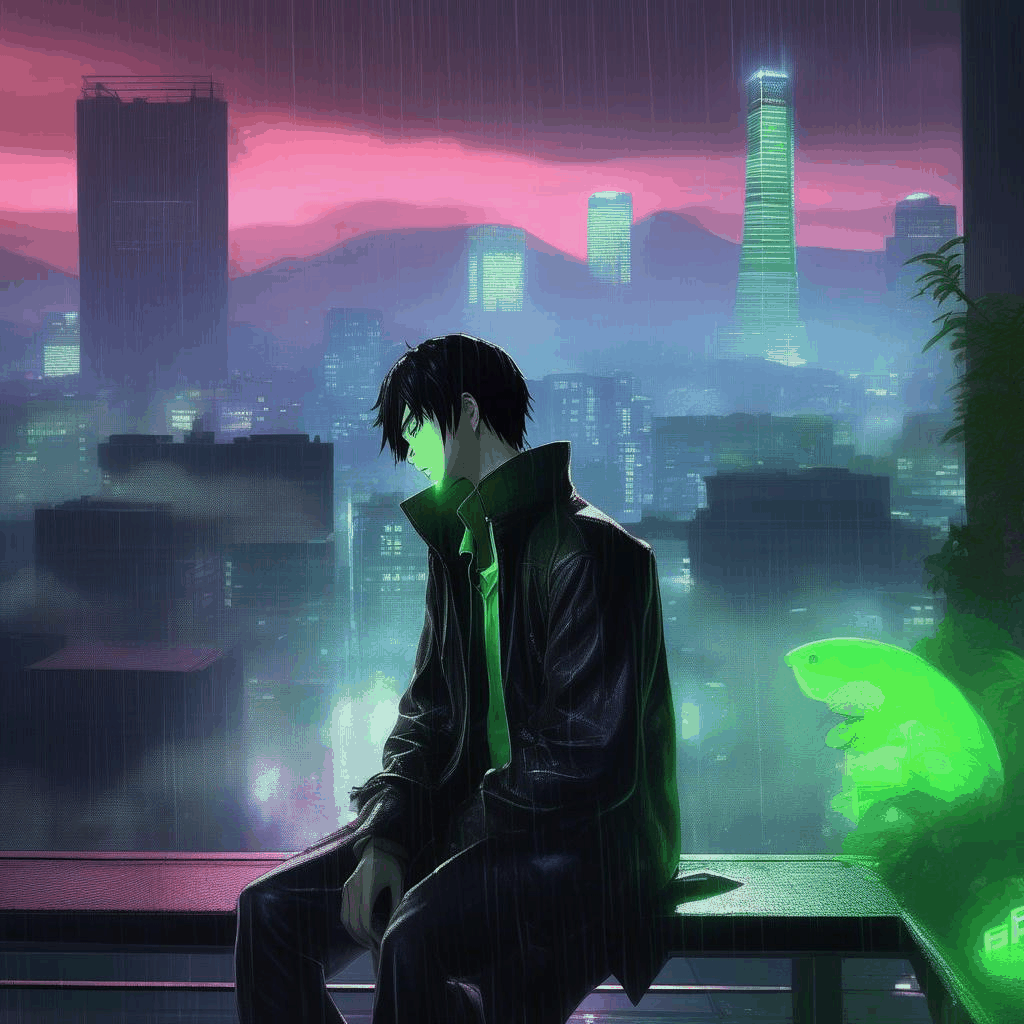

In [7]:
import os
import io
import base64
from typing import TypedDict, Annotated, Sequence, List
from langgraph.graph import Graph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
import google.generativeai as genai
from PIL import Image
from IPython.display import display, Image as IPImage, HTML
import asyncio
import nest_asyncio

# Enable nested asyncio for Colab
nest_asyncio.apply()

# Set Google API key
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Define data structures for the graph state
class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query: Annotated[str, "Input query describing the character and scene"]
    plot: Annotated[str, "Generated plot for the GIF"]
    character_description: Annotated[str, "Detailed description of the main character or object"]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
    image_data: Annotated[List[bytes], "Raw image data for each frame"]
    gif_data: Annotated[bytes, "GIF data in bytes"]

# Initialize the language model for text generation
# Add the api_key parameter explicitly
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GOOGLE_API_KEY  # Add this line
)

# Enhanced printf: Initialization confirmation
print("🔄 [System] Agentic AI system initialized. Establishing capabilities...")

# Define graph functions
def generate_character_description(state: GraphState) -> GraphState:
    print("✨ [Agent] Analyzing input to craft a detailed character description...")
    query = state["query"]
    response = llm.invoke([HumanMessage(content=f"Based on the query '{query}', create a detailed description of the main character or scene.")])
    state["character_description"] = response.content
    print("✅ [Agent] Character description generated successfully.")
    return state

def generate_plot(state: GraphState) -> GraphState:
    print("📖 [Agent] Generating a cohesive plot based on the character description...")
    query = state["query"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"Create a 5-step plot based on the character: {character_description}.")])
    state["plot"] = response.content
    print("✅ [Agent] Plot successfully crafted.")
    return state

def generate_image_prompts(state: GraphState) -> GraphState:
    print("🖼️ [Agent] Designing Stable Diffusion optimized image prompts...")
    plot = state["plot"]
    character_description = state["character_description"]

    # Prompt engineered specifically for Stable Diffusion-friendly outputs
    prompt = f"""
    Based on this plot: '{plot}' and character description: '{character_description}',
    create 5 detailed image prompts optimized for Stable Diffusion that visualize key moments in the story.

    For each prompt:
    1. Start with the main subject and action
    2. Include specific visual details (lighting, camera angle, style)
    3. Add relevant artistic keywords that work well with Stable Diffusion (cinematic, detailed, photorealistic, etc.)
    4. Keep each prompt between 50-150 words for optimal results
    5. Avoid negative prompts or things you don't want to see

    Format each prompt as a numbered list like this:
    1. [Stable Diffusion optimized prompt for scene 1]
    2. [Stable Diffusion optimized prompt for scene 2]
    etc.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Improved extraction logic
    prompts = []
    current_prompt = ""
    in_prompt = False

    for line in response.content.strip().split('\n'):
        line = line.strip()

        # Detect the start of a new numbered prompt
        if line and line[0].isdigit() and len(line) > 1 and line[1] in ['.', ')']:
            if in_prompt and current_prompt:
                prompts.append(current_prompt.strip())
            current_prompt = line.split(line[1], 1)[1].strip()
            in_prompt = True
        # If we're inside a prompt and line is not empty or another numbered item, append to current prompt
        elif in_prompt and line and not (line[0].isdigit() and len(line) > 1 and line[1] in ['.', ')']):
            current_prompt += " " + line

    # Add the last prompt if we were processing one
    if in_prompt and current_prompt:
        prompts.append(current_prompt.strip())

    # If extraction failed, fall back to simpler extraction
    if len(prompts) == 0:
        for line in response.content.strip().split('\n'):
            line = line.strip()
            if line and line[0].isdigit() and len(line) > 1 and line[1] in ['.', ')']:
                try:
                    prompt_text = line.split(line[1], 1)[1].strip()
                    if prompt_text:
                        prompts.append(prompt_text)
                except IndexError:
                    continue

    # Ensure all prompts are SD-optimized by adding common SD enhancers if not present
    sd_enhancers = ["detailed", "high quality", "cinematic lighting", "8k"]
    enhanced_prompts = []

    for p in prompts:
        # Check if prompt already has some enhancers
        has_enhancers = any(enhancer in p.lower() for enhancer in sd_enhancers)

        if not has_enhancers:
            # Add some enhancers if none present
            p += ", " + ", ".join(sd_enhancers)

        enhanced_prompts.append(p)

    # Ensure we have 5 unique prompts with fallbacks optimized for SD
    if len(enhanced_prompts) < 5:
        print("⚠️ [Agent] Warning: Generating fallback SD-optimized prompts")
        fallbacks = [
            f"{character_description} in dramatic scene, cinematic lighting, detailed, 8k, depth of field, professional photography",
            f"Close-up of {character_description} showing emotion, shallow depth of field, detailed features, dramatic lighting, 8k",
            f"Wide shot of story setting, golden hour lighting, atmospheric, cinematic, detailed environment, 8k",
            f"Action scene featuring {character_description}, dynamic pose, motion blur, dramatic angle, detailed, cinematic, 8k",
            f"Emotional moment with {character_description}, soft lighting, bokeh effect, detailed facial expression, cinematic, 8k"
        ]

        for fallback in fallbacks:
            if len(enhanced_prompts) >= 5:
                break
            if fallback not in enhanced_prompts:
                enhanced_prompts.append(fallback)

    # Trim to exactly 5 prompts
    state["image_prompts"] = enhanced_prompts[:5]
    print("✅ [Agent] Stable Diffusion optimized image prompts prepared")

    return state

async def generate_images(state: GraphState) -> GraphState:
    """Generate all images in parallel based on prompts in the state."""
    print("🌟 [Agent] Generating images for all frames...")

    # Get the list of prompts
    prompts = state["image_prompts"]

    # Helper function to generate a single image
    async def _generate_single_image(prompt: str, index: int) -> bytes:
        """Generate a single image using Hugging Face's open-source models."""
        import aiohttp
        import io
        from PIL import Image, ImageDraw, ImageFont

        print(f"🌟 [Agent] Generating image {index+1}: {prompt[:50]}...")

        try:
            # Get API key from environment or replace with your key
            from google.colab import userdata
            HF_API_KEY = userdata.get('HF_API_KEY')
            api_key = HF_API_KEY

            # Use Stable Diffusion from Hugging Face
            api_url = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-xl-base-1.0"

            headers = {
                "Authorization": f"Bearer {api_key}"
            }

            # Prepare the request payload
            payload = {
                "inputs": prompt,
                "parameters": {
                    "num_inference_steps": 30,
                    "guidance_scale": 7.5,
                    "width": 1024,
                    "height": 1024
                }
            }

            # Make the API request
            async with aiohttp.ClientSession() as session:
                async with session.post(api_url, json=payload, headers=headers) as response:
                    if response.status == 200:
                        # HF API returns the image directly as bytes
                        image_bytes = await response.read()
                        print(f"✅ [Agent] Image {index+1} generated successfully with Stable Diffusion.")
                        return image_bytes
                    else:
                        error_text = await response.text()
                        print(f"❌ [Agent] Failed with main model. Status: {response.status}")
                        print(f"Error details: {error_text[:200]}...")

            # If API call fails, create a fallback image
            print(f"⚠️ [Agent] Using fallback image for prompt {index+1}.")
            img = Image.new('RGB', (1024, 1024), color=(index * 40 % 255, 100, 150))
            draw = ImageDraw.Draw(img)

            try:
                font = ImageFont.truetype("Arial", 20)
            except IOError:
                font = ImageFont.load_default()

            draw.text((10, 10), f"Failed to generate image\nPrompt: {prompt[:200]}...",
                      fill=(255, 255, 255), font=font)

            img_byte_arr = io.BytesIO()
            img.save(img_byte_arr, format='PNG')
            img_byte_arr.seek(0)
            return img_byte_arr.getvalue()

        except Exception as e:
            print(f"❌ [Agent] Exception generating image {index+1}: {str(e)}")
            # Return fallback image in case of any exception
            img = Image.new('RGB', (512, 512), color=(200, 50, index * 40 % 255))
            draw = ImageDraw.Draw(img)

            try:
                font = ImageFont.truetype("Arial", 20)
            except IOError:
                font = ImageFont.load_default()

            draw.text((10, 10), f"Error: {str(e)[:100]}", fill=(255, 255, 255), font=font)

            img_byte_arr = io.BytesIO()
            img.save(img_byte_arr, format='PNG')
            img_byte_arr.seek(0)
            return img_byte_arr.getvalue()

    # Generate all images in parallel
    tasks = [_generate_single_image(prompt, i) for i, prompt in enumerate(prompts)]
    image_data_list = await asyncio.gather(*tasks)

    # Update the state with the generated images
    state["image_data"] = image_data_list

    return state

async def create_gif(state: GraphState) -> GraphState:
    print("🔄 [Agent] Assembling images into a GIF...")
    image_data_list = state["image_data"]
    images = [Image.open(io.BytesIO(img_data)) for img_data in image_data_list]

    gif_buffer = io.BytesIO()
    images[0].save(
        gif_buffer,
        format='GIF',
        save_all=True,
        append_images=images[1:],
        duration=1000,
        loop=0
    )
    state["gif_data"] = gif_buffer.getvalue()
    print("✅ [Agent] GIF successfully created.")
    return state

# Set up LangGraph workflow
workflow = Graph()
workflow.add_node("generate_character_description", generate_character_description)
workflow.add_node("generate_plot", generate_plot)
workflow.add_node("generate_image_prompts", generate_image_prompts)
workflow.add_node("generate_images", generate_images)
workflow.add_node("create_gif", create_gif)
workflow.add_edge("generate_character_description", "generate_plot")
workflow.add_edge("generate_plot", "generate_image_prompts")
workflow.add_edge("generate_image_prompts", "generate_images")
workflow.add_edge("generate_images", "create_gif")
workflow.add_edge("create_gif", END)
workflow.set_entry_point("generate_character_description")
app = workflow.compile()

print("\n🌐 [Agent] Workflow schema established.")

# Function to run the workflow and display results
async def run_workflow(query: str):
    print(f"🚀 [Agent] Initiating workflow for query: '{query}'...")
    initial_state = {
        "messages": [],
        "query": query,
        "plot": "",
        "character_description": "",
        "image_prompts": [],
        "image_data": [],
        "gif_data": None
    }

    try:
        result = await app.ainvoke(initial_state)
        print("\n📝 [Agent] Character Description:")
        print(result["character_description"])

        print("\n📖 [Agent] Generated Plot:")
        print(result["plot"])

        print("\n🖼️ [Agent] Image Prompts:")
        for prompt in result["image_prompts"]:
            print(f"- {prompt}")

        if result["gif_data"]:
            print("\n🎉 [Agent] GIF creation successful! Displaying...")
            gif = IPImage(data=result["gif_data"], format='png')
            display(gif)
        else:
            print("⚠️ [Agent] GIF creation failed.")

    except Exception as e:
        print(f"❌ [Agent] Error encountered: {str(e)}")
        import traceback
        traceback.print_exc()  # Print detailed error information

# Get user input for the query (alternate way that should work without JS)
user_query = input("Enter your query for generating a GIF (e.g., A futuristic city with flying cars and neon lights): ")
if user_query:
    await run_workflow(user_query)
else:
    print("⚠️ [System] No query provided. Using default example.")
    await run_workflow("A futuristic city with flying cars and neon lights")